In [85]:
import tensorflow as tf
import numpy as np

import pandas as pd
import reverse_geocoder as rg
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

In [115]:
MIN_LAT=40.7
MAX_LAT=40.81
MIN_LONG=-74
MAX_LONG=-73.75
LAT_BUCKETS=20
LONG_BUCKETS=20

In [195]:
# Real valued columns
passenger_count    = tf.feature_column.numeric_column("passenger_count")

# Create 20 bins for latitude, logitude and create 2 embedding column
pickup_latitude = tf.feature_column.numeric_column("pickup_latitude")
pickup_latitude_feature = tf.feature_column.bucketized_column(
    source_column=pickup_latitude,boundaries = list(np.arange( MIN_LAT, MAX_LAT, (MAX_LAT-MIN_LAT)/LAT_BUCKETS)))

pickup_longitude = tf.feature_column.numeric_column("pickup_longitude")
pickup_longitudee_feature = tf.feature_column.bucketized_column(
    source_column=pickup_longitude,boundaries = list(np.arange(MIN_LONG, MAX_LONG, (MAX_LONG-MIN_LONG)/LAT_BUCKETS)))


dropoff_latitude = tf.feature_column.numeric_column("dropoff_latitude")
dropoff_latitude_feature = tf.feature_column.bucketized_column(
    source_column=dropoff_latitude,boundaries = list(np.arange( MIN_LAT, MAX_LAT, (MAX_LAT-MIN_LAT)/LAT_BUCKETS)))

dropoff_longitude = tf.feature_column.numeric_column("dropoff_longitude")
dropoff_longitude_feature = tf.feature_column.bucketized_column(
    source_column=dropoff_longitude,boundaries = list(np.arange(MIN_LONG, MAX_LONG, (MAX_LONG-MIN_LONG)/LAT_BUCKETS)))



pickup_lat_x_long = tf.feature_column.embedding_column(
    tf.feature_column.crossed_column(
        keys=[pickup_latitude_feature, pickup_longitudee_feature],
        hash_bucket_size=400
    ),
    dimension=20
)

dropoff_lat_x_long = tf.feature_column.embedding_column(
    tf.feature_column.crossed_column(
        keys=[dropoff_latitude_feature, dropoff_longitude_feature],
        hash_bucket_size=400
    ),
    dimension=20
)

# Direct columns from file
vendor = tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('vendor_id', [1,2]))

store_and_fwd_flag =tf.feature_column.indicator_column(tf.feature_column.categorical_column_with_vocabulary_list('vendor_id', ['N','Y']))

# Date columns
month = tf.feature_column.categorical_column_with_vocabulary_list('month', range(1,12))
date = tf.feature_column.categorical_column_with_vocabulary_list('date', range(1,31))
hour = tf.feature_column.categorical_column_with_vocabulary_list('hour', range(0,23))

weekday = tf.feature_column.categorical_column_with_vocabulary_list('weekday', range(0,6))
week_of_the_year = tf.feature_column.categorical_column_with_vocabulary_list('week_of_the_year', range(1,52))

month_date_hour = tf.feature_column.indicator_column(
    tf.feature_column.crossed_column(
        keys=[month, date, hour],
        hash_bucket_size=8928
    )
)



feature_columns = {passenger_count, pickup_lat_x_long, dropoff_lat_x_long, 
                   vendor, month_date_hour, weekday, week_of_the_year}



In [150]:
def normalize_column(col):
    return (col - np.mean(col)) / np.std(col)

In [193]:
def make_input_fn(file_name):
    df = pd.read_csv(file_name, header=0)
    
    def pickup_weekday(row):
        return datetime.date(row['year'], row['month'], row['date']).weekday()

    def week_of_year(row):
        return datetime.date(row['year'], row['month'], row['date']).isocalendar()[1]

    
    df['month'] = df['pickup_datetime'].str.split('-').str[1].astype(np.int32)
    df['year'] = df['pickup_datetime'].str.split('-').str[0].astype(np.int32)
    df['date'] = df['pickup_datetime'].str.split('-').str[2].str.split(' ').str[0].astype(np.int32)
    df['hour'] = df['pickup_datetime'].str.split(' ').str[1].str.split(':').str[0].astype(np.int32)

    df['weekday'] = df.apply(pickup_weekday, axis=1)
    
    df['week_of_the_year'] = df.apply(week_of_year, axis=1)

    del df['pickup_datetime']
    del df['dropoff_datetime']

    del df['year']

    
    del df['id']

#     df.head()
    
    return df
    
    
    
df = make_input_fn('train1.csv')

In [194]:
df.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,month,date,hour,weekday,week_of_the_year
0,2,1,-73.982155,40.767937,-73.964630,40.765602,N,455,3,14,17,0,11
1,1,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,12,0,6,23
2,2,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,19,11,1,3
3,2,1,-74.010040,40.719971,-74.012268,40.706718,N,429,4,6,19,2,14
4,2,1,-73.973053,40.793209,-73.972923,40.782520,N,435,3,26,13,5,12


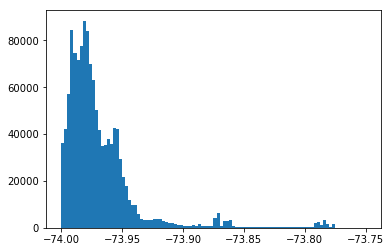

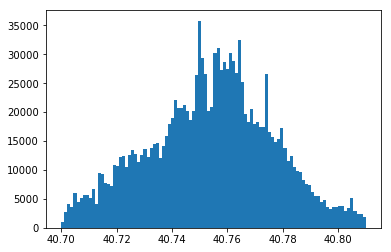

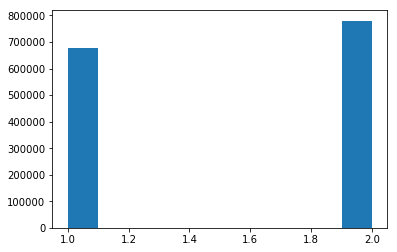

In [154]:
plt.figure(0)
plt.hist(df['dropoff_longitude'], range=(-74,-73.75), bins=100)
plt.show()
plt.figure(1)
plt.hist(df['dropoff_latitude'], range=(40.7,40.81), bins=100)
plt.show()

plt.figure(1)
plt.hist(df['vendor_id'])
plt.show()

In [168]:
pickup_date_col = df.iloc[1][2]
dropoff_date_col = df.iloc[1][3]

pickup_month = int(pickup_date_col.split('-')[1])
pickup_date = int(pickup_date_col.split('-')[2].split(' ')[0])
pickup_hour = int(pickup_date_col.split(' ')[1].split(':')[0])

pickup_weekday = datetime.date(int(pickup_date_col.split('-')[0]),pickup_month, pickup_date).weekday()

dropoff_month = int(dropoff_date_col.split('-')[1])
dropoff_date = int(dropoff_date_col.split('-')[2].split(' ')[0])
dropoff_hour = int(dropoff_date_col.split(' ')[1].split(':')[0])

pickup_weekday = datetime.date(int(dropoff_date_col.split('-')[0]),dropoff_month, dropoff_date).weekday()



In [172]:
df

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435
5,id0801584,2,2016-01-30 22:01:40,2016-01-30 22:09:03,6,-73.982857,40.742195,-73.992081,40.749184,N,443
6,id1813257,1,2016-06-17 22:34:59,2016-06-17 22:40:40,4,-73.969017,40.757839,-73.957405,40.765896,N,341
7,id1324603,2,2016-05-21 07:54:58,2016-05-21 08:20:49,1,-73.969276,40.797779,-73.922470,40.760559,N,1551
8,id1301050,1,2016-05-27 23:12:23,2016-05-27 23:16:38,1,-73.999481,40.738400,-73.985786,40.732815,N,255
9,id0012891,2,2016-03-10 21:45:01,2016-03-10 22:05:26,1,-73.981049,40.744339,-73.973000,40.789989,N,1225
